In [89]:
import numpy as np
import healpy as hp
from tqdm import *
import matplotlib.pyplot as plt

%matplotlib inline

In [71]:
twopc_sens = np.loadtxt("../../GCE-2FIG-CrossCheck/data/outfile2PC.txt")

In [81]:
twopc_map = np.zeros(hp.nside2npix(512))

for idx, item in enumerate(tqdm_notebook(twopc_sens)):
    twopc_map[hp.ang2pix(512,-item[1]*np.pi/180 + np.pi/2,item[0]*np.pi/180)] = item[2]

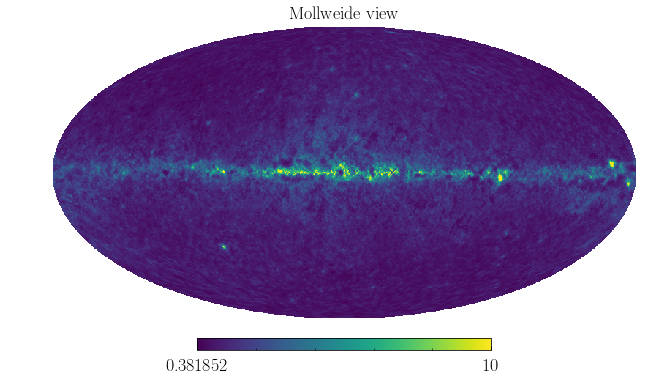

In [82]:
hp.mollview(twopc_map, max = 10)

In [83]:
###############################################################################
# get_efficiency.py
###############################################################################
#
# Evaluate the efficiency at the center of each of the bins using the data
# provided by Dan
#
# Here we infer the longitude efficiency straight from the Fermi data
#
# Written: Nick Rodd, MIT, 8 August 2017
#
###############################################################################

import numpy as np

# All fluxes are in Mev/cm^2/s

# Load the efficiency as specified by Dan
fluxvals = np.array([5.01187234e-07, 7.94328235e-07, 1.25892541e-06,
                    1.99526231e-06, 3.16227766e-06, 5.01187234e-06,
                    7.94328235e-06, 1.25892541e-05, 1.99526231e-05,
                    3.16227766e-05, 5.01187234e-05, 7.94328235e-05,
                    1.25892541e-04, 1.99526231e-04])
bvals = np.array([1., 3., 5., 7.5, 10.5, 14., 18.])

efficiency = np.zeros((len(fluxvals),len(bvals)))

efficiency[:, 0] = [0.00354610, 0.00411523, 0.01162791, 0.00854701, 0.05857741,
                    0.17112299, 0.22916667, 0.28140704, 0.32989691, 0.42405063,
                    0.46601942, 0.60000000, 0.80000000, 1.00000000]
efficiency[:, 1] = [0.00892857, 0.01785714, 0.06493506, 0.15789474, 0.30909091,
                    0.40816327, 0.62162162, 0.76595745, 0.70833333, 0.81159420,
                    0.88636364, 0.90000000, 0.94339623, 1.00000000]
efficiency[:, 2] = [0.01190476, 0.01086957, 0.11627907, 0.38095238, 0.69411765,
                    0.83950617, 0.87671233, 0.90647059, 0.91769231, 0.92444444,
                    0.95444444, 0.97444444, 1.00000000, 1.00000000]
efficiency[:, 3] = [0.00000000, 0.04166667, 0.14782609, 0.39622642, 0.71739130,
                    0.74712644, 0.89189189, 0.85915493, 0.85365854, 0.90058824,
                    0.92647059, 0.95476190, 1.00000000, 1.00000000]
efficiency[:, 4] = [0.00925926, 0.06603774, 0.20408163, 0.50980392, 0.85294118,
                    0.84615385, 0.88505747, 0.92222222, 0.94366197, 0.95522388,
                    0.94339623, 0.95000000, 1.00000000, 1.00000000]
efficiency[:, 5] = [0.00000000, 0.05590062, 0.19298246, 0.52307692, 0.79032258,
                    0.85600000, 0.85964912, 0.90740741, 0.90774194, 0.89156627,
                    0.92461538, 0.89500000, 1.00000000, 1.00000000]
efficiency[:, 6] = [0.02142857, 0.05263158, 0.20833333, 0.55905512, 0.71052632,
                    0.76237624, 0.80357143, 0.87878788, 0.92391304, 0.95555556,
                    0.93750000, 0.95000000, 1.00000000, 1.00000000]

# Load the array of bvals and flux vals for our bins
our_bvals = np.abs([18.33333333, 15., 11.66666667, 8.33333333, 5., 1.66666667,
                    -1.66666667, -5., -8.33333333, -11.66666667, -15., -18.33333333])

# 6 flux bins fro 1e-6 to 1e-5 and 2 from 1e-5 to 1e-4, evaluate midpoints below
fluxvals1 = 10**(1./12.+np.linspace(-6,-5,7)[0:6])
fluxvals2 = 10**(0.25+np.linspace(-5,-4,3)[0:2])
our_fluxvals = np.append(fluxvals1,fluxvals2)

# Find flux interpolation values - this is the integer in fluxvals to go to
our_flux_interp = np.interp(our_fluxvals, fluxvals, np.arange(len(fluxvals), dtype=float))

# Now convert efficiency to be at our fluxes, but original b values
efficiency_ourflux = np.zeros((len(bvals),len(our_fluxvals)))

for i in range(7):
    for j in range(len(our_fluxvals)):
        efficiency_ourflux[i,j] = np.interp(our_flux_interp[j],np.arange(len(fluxvals), dtype=float), efficiency[:,i])

# Find b interpolation values - this is the integer in the bvals to go to
our_b_interp = np.interp(our_bvals, bvals, np.arange(len(bvals), dtype=float))

# Now convert efficiency to our b values and we're done!
our_efficiency = np.zeros((len(our_bvals),len(our_fluxvals)))
for i in range(len(our_bvals)):
    for j in range(len(our_fluxvals)):
        our_efficiency[i,j] = np.interp(our_b_interp[i], np.arange(len(bvals), dtype=float), efficiency_ourflux[:,j])

# Now let's try and get the longitude dependence from the data 
# Need to load the fermi plugin to load the Fermi data - pointing to this on Erebus
import sys
import healpy as hp
    
# Set the data to be the 2PC map from above
data = twopc_map

# Setup coordinates
theta, phi = hp.pix2ang(512, range(hp.nside2npix(512)))
barr = 180./np.pi*(np.pi/2. - theta)
larr_0360 = phi*180./np.pi
larr = ((larr_0360 + 180.) % 360.)-180.

# Now calculate the full efficiency
full_efficiency = np.zeros((len(our_bvals),len(our_bvals),len(our_fluxvals)))
for i in range(len(our_bvals)): 
    # Determine l weighting factor - higher weight where less data
    lweight = np.zeros(len(our_bvals))
    for j in range(len(our_bvals)):
        roi = np.where((barr < 20.-10./3.*i) & (barr > 20.-10./3.*(i+1)) & (larr < 20.-10./3.*j) & (larr > 20.-10./3.*(j+1)))[0]
        lweight[j] = 1.0 / np.sum(data[roi])
    lweight /= np.mean(lweight)

    #print lweight

    # Now to the full efficiency
    for j in range(len(our_bvals)):
        for k in range(len(our_fluxvals)):
            full_efficiency[j,i,k] = our_efficiency[i,k]*lweight[j]
            # Artificially truncate to 1 - this needs to be fixed!
            if full_efficiency[j,i,k] > 1.:
                full_efficiency[j,i,k] = 1.

print full_efficiency
print np.shape(full_efficiency)


[[[ 0.13545327  0.32074357  0.44965884 ...,  0.56912728  0.64092825
    0.66168598]
  [ 0.12159937  0.28891469  0.43851425 ...,  0.56630912  0.60571957
    0.61603399]
  [ 0.16265879  0.36816332  0.59508965 ...,  0.767597    0.80961557
    0.81708028]
  ..., 
  [ 0.17191411  0.38911189  0.62895037 ...,  0.81127343  0.85568286
    0.86357231]
  [ 0.16838306  0.40007064  0.60722657 ...,  0.78418877  0.83876184
    0.85304459]
  [ 0.20297255  0.48062434  0.67379989 ...,  0.85281966  0.9604112
    0.99151602]]

 [[ 0.13212506  0.31286259  0.43861029 ...,  0.55514327  0.62518002
    0.64542772]
  [ 0.12211624  0.29014274  0.44037817 ...,  0.56871625  0.60829421
    0.61865247]
  [ 0.14912027  0.33752011  0.54555877 ...,  0.70370787  0.74222913
    0.74907252]
  ..., 
  [ 0.18378753  0.41598629  0.67238947 ...,  0.86730485  0.91478146
    0.92321581]
  [ 0.18600108  0.44193029  0.67076108 ...,  0.86623895  0.92652204
    0.9422992 ]
  [ 0.25369422  0.60072959  0.84217861 ...,  1.          1.

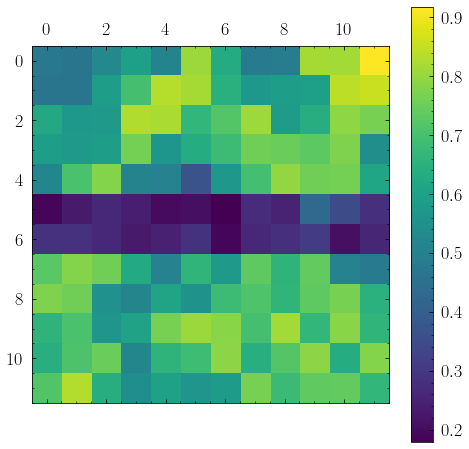

In [91]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(np.transpose(np.mean(full_efficiency,axis=2)), interpolation='nearest')
fig.colorbar(cax)
plt.show()

In [93]:
np.save("../data/omega_ijk_2PC.npy", full_efficiency)